# In fase di perfezionamento

# Machine Learning lab - 05 - Data Reduction
Source:
- Tabular Playground Series - Jun 2021
- https://www.kaggle.com/competitions/tabular-playground-series-jun-2021

We have available two data files, `train.csv` and `test.csv`. The first one will be used to find the best classification models for some performance measures, the second one is unsupervised, we will make the predictions for it using the best model and save it into a new file.

## Unsupervised attribute selection

Workflow:

1. load `train.csv` and do some exploration (the number of columns is a bit large, avoid using `pairplots`, it would be very slow and undreadable)
2. cancel useless columns, if any, use as target the `target` column, separate predicting from target into `X_full` and `y`
3. Try unsupervised attribute selection: use `PCA` to keep only the transformed features able to explain, cumulatively, 90% of the total variance
4. store in X the remaining, transformed variables
5. split the X and y data into __train__ and __test__; since the file is quite large, for a faster development use not more than 2000 rows for training, and the remaining for testing
6. show two pie charts of the distribution of classes into `y_train` and `y_test` to verify if they are similar
7. optimize with `GridSearchCV` DecistionTree and RandomForest, using two different measures: `accuracy` and `f1_macro`
8. show the confusion matrices of the best model for `accuracy` and `f1_macro` and comment the differences
9. For the final test, upload the file `test.csv`, apply the same data reduction applied to `train.csv`,
10. make the prediction using the models previously optimized
11. show the confusion matrices and comment the comparison with the ones previously generated

In [1]:
#Tabular Playground Series - Jun 2021
#https://www.kaggle.com/competitions/tabular-playground-series-jun-2021


import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
# google_drive_path = '/content/drive/MyDrive/Colab Notebooks/'
file_path = "lab5-data/"

In [4]:
# !ls /content/drive/MyDrive/Colab\ Notebooks

In [5]:

train_size = 0.01 # train size chosen to have a few tousands of elements
cutoff_variance = .8 # the total amount of variance explained by the selected transformed features
cv = 5
random_state = 42
np.random.seed(random_state) # this sets the random sequence. Setting only this the repeatability is guaranteed
                             # only if we re-execute the entire notebook

train_ds = pd.read_csv(file_path+'train.csv')

print("Shape of the training data {}".format(train_ds.shape))

Shape of the training data (200000, 77)
Shape of the test data (100000, 76)


In [6]:
# show 10 random records
train_ds.sample(n=10, axis=0, replace=False, random_state = random_state)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
119737,119737,0,0,15,0,0,0,0,0,11,...,0,0,1,0,0,0,1,0,0,Class_3
72272,72272,0,0,1,0,0,1,0,0,0,...,0,0,0,0,3,0,0,0,0,Class_6
158154,158154,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,Class_6
65426,65426,6,0,0,0,0,2,0,0,0,...,3,7,2,1,0,0,0,1,1,Class_8
30074,30074,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,Class_1
23677,23677,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,Class_2
134858,134858,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,1,0,0,0,Class_9
176418,176418,0,0,0,0,0,14,0,0,0,...,0,0,1,1,1,2,0,0,0,Class_2
132467,132467,0,2,1,3,1,0,0,7,8,...,0,1,0,0,20,18,1,0,1,Class_8
4082,4082,40,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,Class_5


In [26]:
train_ds.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000
mean,99999.500000,0.972710,1.168365,2.219325,2.296735,0.793530,1.431105,1.010695,0.673090,1.94398,...,1.798040,0.508695,1.827300,0.910370,1.603585,1.219210,0.806895,1.282925,2.94021,0.632005
std,57735.171256,3.941836,3.993407,6.476570,7.551858,2.935785,5.162746,3.949231,2.234949,3.93133,...,5.053014,1.867330,7.188924,3.835182,4.877679,4.826003,2.458741,4.261420,10.78465,3.925310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,49999.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,99999.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,149999.250000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.00000,...,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.00000,0.000000
max,199999.000000,61.000000,51.000000,64.000000,70.000000,38.000000,76.000000,43.000000,30.000000,38.00000,...,54.000000,24.000000,79.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.00000,52.000000


In [8]:
train_ds.nunique().sort_values(ascending=False)[:30]

id            200000
feature_15       105
feature_60        99
feature_59        92
feature_73        91
feature_46        87
feature_28        78
feature_32        77
feature_54        72
feature_61        70
feature_63        70
feature_19        66
feature_55        65
feature_47        63
feature_62        61
feature_3         59
feature_29        58
feature_67        57
feature_41        56
feature_22        55
feature_5         55
feature_43        53
feature_69        52
feature_9         51
feature_24        50
feature_74        50
feature_70        49
feature_27        49
feature_51        49
feature_2         48
dtype: int64

In [9]:
# train_ds['feature_15'].sort_values(ascending=False)[:20]

In [10]:
target = 'target'
classes = train_ds[target].unique()
classes.sort()
print(classes)

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']


In [11]:
le = LabelEncoder()
y = le.fit_transform(train_ds[target])
X_full = train_ds.drop(['id', target], axis=1)


In [12]:
X_full.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,0,0,6,1,0,0,0,0,7,0,...,3,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,3,0,0,...,8,0,0,0,0,1,0,0,0,0
3,0,0,7,0,1,5,2,2,0,1,...,0,0,4,0,2,2,0,4,3,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
model_lbls = ['dt' # decision tree
             #,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             #,'lp'   # linear perceptron
             #,'svc'  # support vector
             #,'knn'  # k nearest neighbours
             #,'adb'  # adaboost
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      # 'max_depth': [*range(4,30)]
                      'max_depth': [*range(4,30,4)]
                    #  ,'n_estimators':[*range(20,80,5)]
                     ,'n_estimators':[*range(10,30,5)]
                     ,'class_weight': [None,'balanced']
                      }]
          }

}


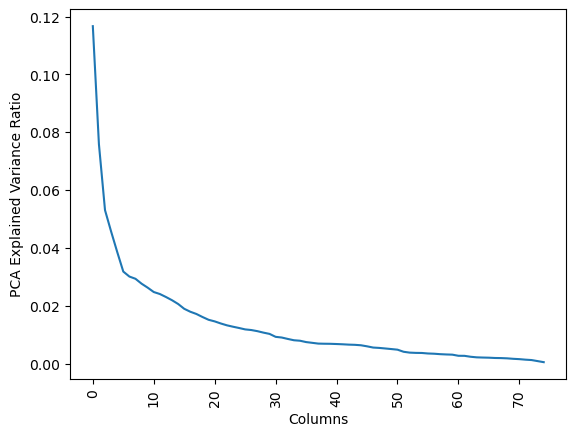

In [14]:
pca = PCA()

X_trans = pca.fit_transform(X_full)

# print(pca.explained_variance_ratio_ )

plt.plot(range(X_full.shape[1]), pca.explained_variance_ratio_);

plt.xlabel('Columns')
plt.ylabel('PCA Explained Variance Ratio')

plt.xticks(rotation = 90)

plt.show()


In [15]:
explained_variances = pca.explained_variance_ratio_

# Sort the explained variance ratios in descending order
sorted_variances = sorted(explained_variances, reverse=True)


# Calculate the cumulative sum of the explained variance ratios
cumulative_variances = np.cumsum(sorted_variances)

# Find the index i of the first principal component where the cumulative sum exceeds 0.05
cutoff_index = np.argmax(cumulative_variances > cutoff_variance)
print("Used the top {} transformed variables".format(cutoff_index))

# Keep the first i principal components and discard the rest
X = pca.transform(X_full)[:, :cutoff_index+1]


Used the top 30 transformed variables


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    , train_size = train_size
                                                    , random_state = random_state) # default Train 0.75- Test 0.25
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X.shape[1]))

There are 2000 samples in the training dataset
There are 198000 samples in the testing dataset
Each sample has 31 features


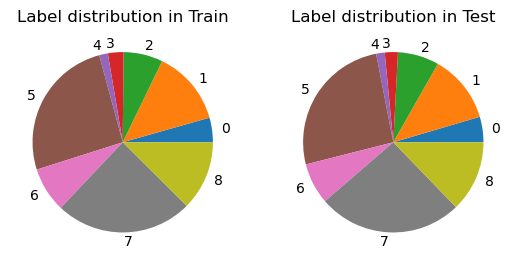

In [17]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[0]);
ax1.set_title("Label distribution in Train")
ax2.pie(np.unique(y_test, return_counts=True)[1], labels=np.unique(y_test, return_counts=True)[0]);
ax2.set_title("Label distribution in Test")
plt.show()


In [18]:
scorings = ['accuracy'
            # ,'precision_macro'
            # ,'recall_macro'
            ,'f1_macro'
            ]

In [19]:
from sklearn.model_selection import ParameterGrid
trials = {lbl: len(list(ParameterGrid(models[lbl]['param']))) for lbl in model_lbls}
trials

{'dt': 38, 'rf': 56}

In [20]:
clfs = []
results = pd.DataFrame(columns=['scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'])



In [21]:
for scoring in scorings:
    for m in model_lbls:
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=cv,
                           scoring = scoring,

                           )
        clf.fit(X_train, y_train)
        clfs.append(clf)
        y_true, y_pred = y_test, clf.predict(X_test)
        # y_preds.append(y_pred)
        cr = classification_report(y_true,y_pred, output_dict=True
                                   , zero_division=1
                                   )
        results.loc[len(results)] = [scoring,models[m]['name'],clf.best_params_
                                    # ,(clf.cv_results_['mean_fit_time'].sum()+clf.cv_results_['mean_score_time'].sum())*n_splits
                                    ,cr['accuracy']
                                    ,cr['macro avg']['precision']
                                    ,cr['macro avg']['recall']
                                    ,cr['macro avg']['f1-score']]

In [23]:
for score in scorings:
    scoring_filter = score
    display(results[results.scoring==scoring_filter]\
                .sort_values(by=scoring_filter,ascending=False)\
                .drop('scoring',axis=1)\
                .style.format(precision=3)\
                .set_caption('Results for scoring "{}"'.format(scoring_filter)))

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
1,Random forest,"{'class_weight': None, 'max_depth': 4, 'n_estimators': 25}",0.327,0.679,0.163,0.130
0,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.307,0.682,0.148,0.126


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
3,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 25}",0.264,0.155,0.163,0.157
2,Decision Tree,"{'class_weight': None, 'max_depth': 7}",0.283,0.149,0.148,0.133


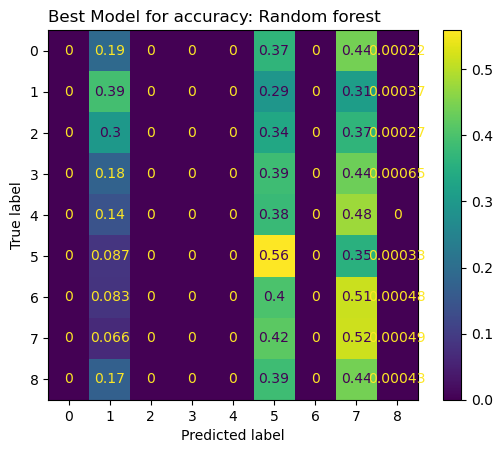

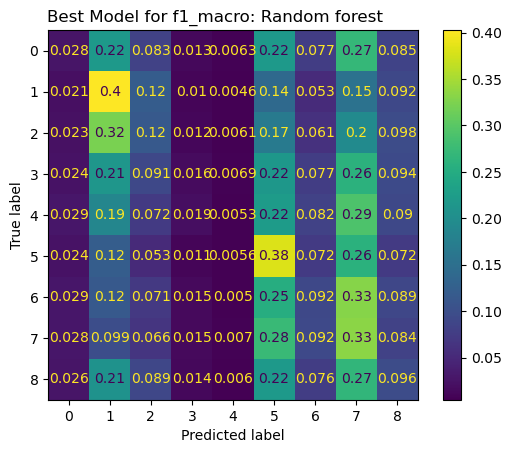

In [24]:
for score in scorings:
    scoring_filter = score
    # bests[score] = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)
    best_row = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)
    disp = ConfusionMatrixDisplay.from_estimator(X=X_test, y=y_test, estimator = clfs[best_row], normalize='true')
    # disp.ax_.set_title("Best Model for {}: {}".format(score,results.at[bests[score],'model']))
    disp.ax_.set_title("Best Model for {}: {}".format(score,results.at[best_row,'model']))
plt.show()

## Final step - make a prediction
9. For the final test, upload the file `test.csv`, apply the same data reduction applied to `train.csv`
    - in order to avoid confusion, we will call this dataset `u_test` (unsupervised)
10. make the prediction using the models previously optimized
    - train the best estimator for `f1_macro` with the __entire__ training set
    - predict the target for `u_test` 
    - save a new file `test_predicted.csv` with the original test data and the predictions for the target
11. show a pie chart of the distribution of classes in the predictions

In [31]:
u_test_ds = pd.read_csv(file_path+'test.csv').drop('id', axis=1)
print("Shape of the test data {}".format(u_test_ds.shape))

Shape of the test data (100000, 75)


In [32]:
X_u_test = pca.transform(u_test_ds)[:, :cutoff_index+1]


In [35]:
results

,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
0,accuracy,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.307162,0.682211,0.148385,0.125871
1,accuracy,Random forest,"{'class_weight': None, 'max_depth': 4, 'n_esti...",0.326530,0.679213,0.163182,0.129577
2,f1_macro,Decision Tree,"{'class_weight': None, 'max_depth': 7}",0.282652,0.149385,0.147939,0.132758
3,f1_macro,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, '...",0.263909,0.155441,0.163396,0.156594


In [39]:
scoring_filter = 'f1_macro'
best_row = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)
best_row
# best_f1_macro = results.loc[best_row,'model']()

TypeError: 'str' object is not callable

In [41]:
y = clf.best_estimator_.predict(X_u_test)

In [42]:
y.shape

(100000,)

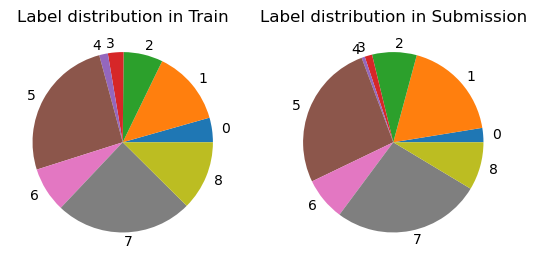

In [44]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[0]);
ax1.set_title("Label distribution in Train")
ax2.pie(np.unique(y, return_counts=True)[1], labels=np.unique(y, return_counts=True)[0]);
ax2.set_title("Label distribution in Submission")
plt.show()